!pip install pysynphot

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pysynphot import spectrum as S
from glob import glob

import scipy
from scipy.optimize import minimize
from scipy.constants import k,c,h
from scipy import integrate

from astropy import units as u
from astropy import constants as const
from astropy.constants import G,R_jup,R_sun,M_jup,M_sun,au,pc,sigma_sb

/home/yterada/anaconda3/envs/dmtau/lib/python3.8/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/home/yterada/anaconda3/envs/dmtau/lib/python3.8/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


# Blackbody definition

In [2]:
#Input wavelength: nm

#[W/m**2/m] 
def blackbody(temp,lam,nu):
    lam = 1e-9 * lam
    nu = c/lam
    #[erg/s/cm**2/cm]
    B_lambda = 2*h*c**2 / (lam**5 * (np.exp(h*c/ (lam*k*temp)) - 1))
    B_freq = 2*h*nu**3 / (c**3 * (np.exp(h*nu/(k*temp)) - 1))
    return B_lambda, B_freq



#The following functions are for testing

#fixed temperature
T = 5777

##calculate bb [W/m**2/m]
def _bb(lam):
    lam = 1e-9 * lam
    B_lambda = (2*h*(c**2) )/ (lam**5 * (np.exp(h*c/ (lam*k*T)) - 1))
    
    return B_lambda

##calculate bb [W/m**2/Hz]
def _bb_f(lam):
    lam = 1e-9 * lam
    nu = c/lam
    B_freq = 2*h*nu**3 / (c**3 * (np.exp(h*nu/ (k*T)) - 1))
    
    return B_freq

# The Sun

In [3]:
#Literature

#T_sun = 5777K
print(' L_sun = {:.2e}\n'.format(const.L_sun))
F_total = sigma_sb * 5777**4
L_sb = F_total * 4 * np.pi * R_sun**2
print(' L_sun (from Stefan–Boltzmann law) = {:.2e}\n'.format(L_sb))

 L_sun = 3.83e+26 W

 L_sun (from Stefan–Boltzmann law) = 3.84e+26 W / K4



 L_sun_test = 3.76e+35 m2



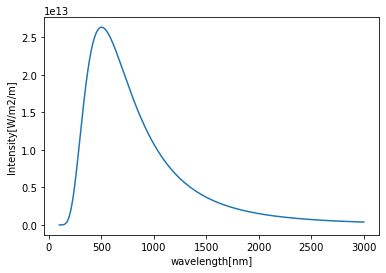

In [4]:
#test: calculate Luminosity of the Sun
#The blackbody radiation from the Sun: 100nm ~ 2500nm(3000nm)
ar_lam = np.arange(1e2, 3e3, 1)
ar_bb = np.empty(len(ar_lam))
for i in range(len(ar_lam)):
    ar_bb[i] = _bb(ar_lam[i])
    
plt.plot(ar_lam, ar_bb)
plt.xlabel('wavelength[nm]')
plt.ylabel('Intensity[W/m2/m]')

# Luminosity = F_total * surface area(4*pi*R_sun**2) = pi * integral(Blackbody,all wavelength) * surface area 
f_sun, f_sun_err = integrate.quad(_bb, 100, 3e3)
L_s_test = f_sun * np.pi**2 * 4.0 * R_sun**2
print(' L_sun_test = {:.2e}\n'.format(L_s_test))

# Transmission

['./Generic_Johnson.B.dat', './Generic_Johnson.I.dat', './Generic_Johnson.R.dat', './Generic_Johnson.V.dat', './Kepler_Kepler.K.dat']


Text(0.5, 0, 'wavelength[nm]')

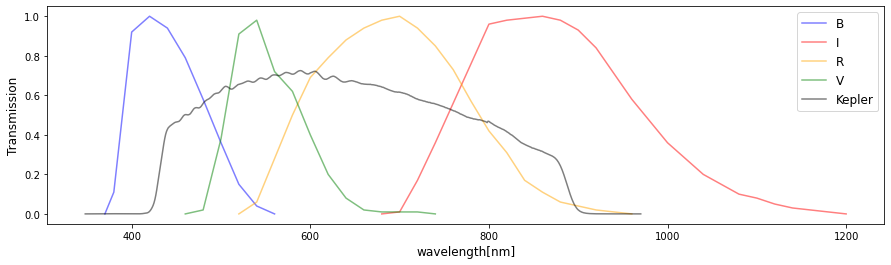

In [41]:
datadir = '.'
path    = os.path.join(datadir,'*.dat')
file_list = glob(path)
file_list = sorted(file_list)
print(file_list)

filt={}
bands = 'B,I,R,V,Kepler'.split(',')
for fname,b in zip(file_list,bands):
    df=pd.read_table(fname, delimiter=' ', parse_dates=True, header=None)
    #df = df.drop('Unnamed: 0',axis=1)
    #df = df.set_index('GJD-2450000')
    filt[b] = df
filt.keys()

lam_col =  'lambda'
trans_col  =  'transmission'

colors='b,r,orange,g,black'.split(',')
fig,ax = plt.subplots(1,1,figsize=(15,4))

n=0
for b,c in zip(bands,colors):
    df = filt[b]    
    lam_nm = df[0]*0.1
    trans = df[1]
    
    ax.plot(lam_nm, trans, label=b, color=c, alpha=0.5)
    ax.set_ylabel('Transmission', fontsize=12)
    n+=1
plt.legend(loc='upper right',fontsize=12)
plt.xlabel('wavelength[nm]',fontsize=12)

In [ ]:
f,ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].plot(lam, trans)
ax[0].set_xlabel('wavelength(Angstroam)')
ax[0].set_title('Kepler transmission')

array_lam = lam
array_bb_lam0 = np.empty(len(lam))
array_bb_lam = np.empty(len(lam))
array_bb_freq = np.empty(len(lam))

temp=4000

for i in range(len(array_lam)):
    array_bb_lam0[i] = blackbody(temp,array_lam[i],freq[i])[0]
    array_bb_lam[i] = blackbody(temp,array_lam[i],freq[i])[0] * trans[i]
    array_bb_freq[i] = blackbody(temp,array_lam[i],freq[i])[1] * trans[i]
    
ax[1].plot(array_lam, array_bb_lam0, label='bb')
ax[1].plot(array_lam, array_bb_lam, label='bb * transmission')
ax[1].legend(loc="upper left", fontsize=10)


f_obs_freq = sum(array_bb_freq) * ((2*R_sun)**2/(10*pc)**2)
f_obs_freq_abs = sum(array_bb_freq) * ((2*R_sun)**2/(10*pc)**2)
print(f_obs_freq)

ap_mag = -2.5 * np.log10(f_obs_freq * 1e26) + 2.5 * np.log10(sum(trans)) 
print(ap_mag)

#f_k2_disk = sum(array_bb_freq) * np.pi * (R_sun.cgs)**2
#print(f_k2_disk)
##f_k2_obs_freq = f_k2_disk / (au.cgs)**2
#print(f_k2_obs_freq)

Text(0.5, 1.0, 'alpha_lyr_stis_010.fits')

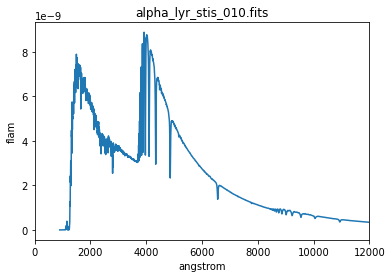

In [9]:
#fluxunits: [erg/s/cm2/A]
plt.plot(S.Vega.wave, S.Vega.flux)
plt.xlim(0, 12000)
plt.xlabel(S.Vega.waveunits)
plt.ylabel(S.Vega.fluxunits)
plt.title(os.path.basename(S.Vega.name))

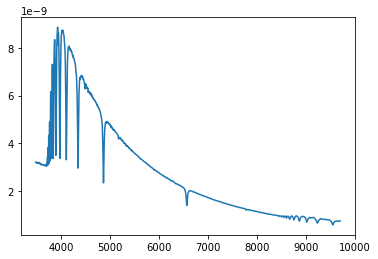

In [10]:
vega_kepler_flux = S.Vega.flux[(S.Vega.wave>3479.0) & (S.Vega.wave<9701.0)]
vega_kepler_wave =  S.Vega.wave[(S.Vega.wave>3479.0) & (S.Vega.wave<9701.0)]
plt.plot(vega_kepler_wave, vega_kepler_flux )